## The CartPole Environment
Source: https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py

### Actions Space = {0, 1} = `Discrete(2)`
* 0 -> Push cart to the left
* 1 -> Push cart to the right

### Observations = `Box(4)`
A 4-element array of floats:

    Position    Observation               Min                     Max
    0       Cart Position             -4.8                    4.8
    1       Cart Velocity             -Inf                    Inf
    2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
    3       Pole Angular Velocity     -Inf                    Inf


### Reward:
Reward is 1 for every step taken, including the termination step


### Starting State:
All observations are assigned a uniform random value in $[-0.05, ... ,0.05]$

### Episode Termination:
* Pole Angle is more than 12 degrees.
* Cart Position is more than 2.4 units from the origin (center of the cart reaches the edge of the display).
* Episode length is greater than 200.

### Solved Requirements:
Considered solved when the average return is greater than or equal to 195.0 over 100 consecutive trials.

------------------------------------------------------------

In [84]:
import gym
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras import Sequential
#from tensorflow.keras.optimizers import Adam # avoid naming conflict
from tensorflow.keras import optimizers
from tensorflow.python.keras.models import load_model

import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
from torch.optim import Adam
from torch import tensor
import numpy as np
import gym
from gym.spaces import Discrete, Box

In [2]:
env = gym.make('CartPole-v0')

# print(env.action_space)
# print(env.observation_space)

for episode_index in range(1):
    observation = env.reset()
    for t in range(500):
        env.render()
        
        action = env.action_space.sample()
        
        observation, reward, done, info = env.step(action)
        
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
            
env.close()

Episode finished after 17 timesteps


### Create Keras or PyTorch Neural Networks as the policy

In [3]:
# source: https://github.com/karnigili/ReinforcementLearning/blob/master/Tutorials/REINFORCE.ipynb

def keras_create_model(input_shape, output_shape, learning_rate=1e-3):
    ''' builds the model using keras'''
    model = Sequential()

    # input shape is of observations
    model.add(Dense(24, input_shape=input_shape, activation="relu"))
    
    #model.add(Dropout(0.5)) 
    
    # introduce a relu layer 
    model.add(Dense(12, activation="relu"))
    #model.add(Dropout(0.5))    

    # output shape is according to the number of action
    # The softmax function outputs a probability distribution over the actions
    model.add(Dense(output_shape, activation="softmax")) 
    model.compile(loss="categorical_crossentropy", 
            optimizer=optimizers.Adam(lr=learning_rate))

    return model

In [4]:
keras_model = keras_create_model(env.observation_space.shape, env.action_space.n)

In [113]:
# source: https://github.com/openai/spinningup/blob/master/spinup/examples/pytorch/pg_math/1_simple_pg.py

def mlp(sizes, activation=nn.Tanh, output_activation=nn.Softmax):
    # Build a feedforward neural network.
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)

In [114]:
sizes=[4]+[32]+[2] # input size, hidden layer size, output size
pytorch_model = mlp(sizes)

## REINFORCE

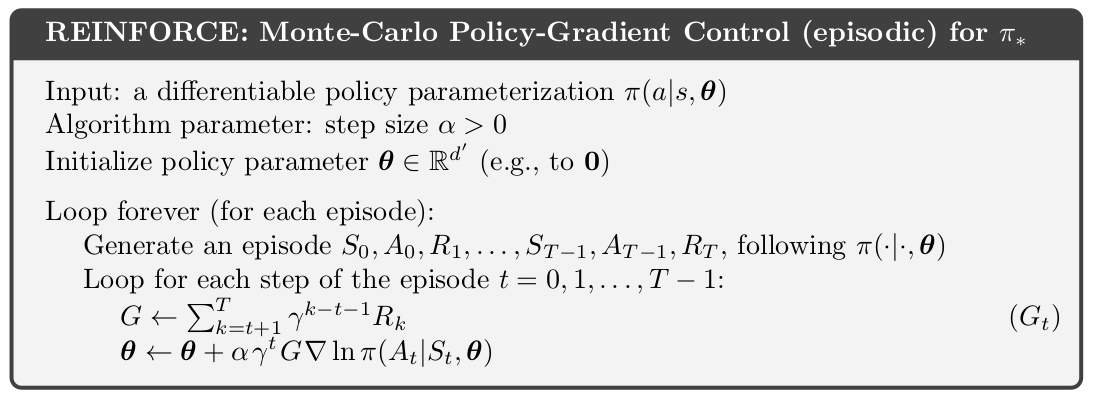

In [115]:
from IPython.display import Image, display

display(Image("REINFORCE_Stutton_and_Barto.png"))

In [125]:
class REINFORCE():
    def __init__(self, policy, alpha=1e-4, gamma=0.99):
        self.policy = policy
        self.obs = []
        self.actions = []
        self.rewards = []
        self.alpha = alpha
        self.gamma = gamma
        self.theta = list(self.policy.parameters())
        self.distribution = Categorical
    
    @staticmethod
    def convert_to_tensor(x):
        if type(x) != torch.Tensor:
            x = tensor(x, dtype=torch.float32)
        return x
    
    def remember(self, obs, action, reward, next_obs):
        self.obs.append(obs)
        self.actions.append(action)
        self.rewards.append(reward)
    
    def clear_memory(self):
        self.obs = []
        self.actions = []
        self.rewards = [] 
    
    def choose_action(self, observation):
        observation = self.convert_to_tensor(observation)
        print("new obs", observation)
        action_probabilities = self.policy(tensor(observation, dtype=torch.float32))
        print(action_probabilities)
        action = self.distribution(action_probabilities).sample()
        return action.item() # Convert tensor to integer
    
    def get_action_log_prob(self, observation, action):
        action_probabilities = self.policy(observation)
        return self.distribution(action_probabilities).log_prob(action) 
        
    def get_return(self, t):
        """
        Inputs:
            t [int]: the step index from which to calculate future returns
            
        Note: not the most computationally efficient way to do this
        """
        ret = 0 # return
        k = t
        for r in self.rewards[t:]:
            k += 1
            ret += self.gamma**(k - t - 1) * r
        
        return ret

            
    def learn(self):
        # Start by updating one step
        G = self.get_return(0) 

In [126]:
agent = REINFORCE(pytorch_model)
agent.rewards = list(range(10))
agent.get_return(7)

23.7409

In [127]:
env = gym.make('CartPole-v0')
n_episodes = 1
max_steps = 1

agent = REINFORCE(pytorch_model)

for _ in range(n_episodes):
    observation = env.reset()
    for _ in range(max_steps):
        #env.render(mode='human')
        
        print(observation)
        action = agent.choose_action(observation)
        
        next_observation, reward, done, info = env.step(action)
        
        agent.remember(observation, action, reward, next_observation)
        
        if done:
            break
        
env.close()

[ 0.02175435  0.01429151  0.00320842 -0.02314045]
new obs tensor([ 0.0218,  0.0143,  0.0032, -0.0231])
tensor([0.5436, 0.4564], grad_fn=<SoftmaxBackward>)


/home/cfarquhar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/cfarquhar/.local/lib/python3.6/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [103]:
a = tensor([1,2,3])
print(a)
b = tensor(np.array([1,2,3]))
print(b)
print(type(a) == torch.Tensor)
print(a.shape)
print(len(a))

tensor([1, 2, 3])
tensor([1, 2, 3])
True
torch.Size([3])
3
